In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.callbacks import * 
from fastai.text import * 
import io
import pathlib
from fastai_sentencepiece import *
from filetokenizer import *
from languagemodelloader import *
import matplotlib.pyplot as plt

In [3]:
lang="en"
#pathData       = Path("../../data/nlp")
pathData       = Path("../nlp-data")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

In [4]:
favorite_numbers = [6, 57, 4, 7, 68, 95]
my_iterator = iter(favorite_numbers)
for n in my_iterator:
    print(n)

6
57
4
7
68
95


In [5]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def mimmax(v):
    v_min,v_max = min(v), max(v)
    if   v_min==v_max and v_min==0: v_min,v_max = v_min-.1, v_min+.1 
    elif v_min==v_max :             v_min,v_max = v_min-.1*v_min,v_max+.1*v_max
    return v_min,v_max
    
def plot_hyperparameters( x, ys:dict ):
    def setAxis(ax,k,v):
        ax.set_ylabel(k)
        p, = ax.plot(x, v, label=k)
        ax.axis["left"].label.set_color(p.get_color())
        limits = mimmax(v)
        ax.set_ylim(limits)
        if limits[0] < 1e-1 and limits[1] < 1e-1:ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    par2 = host.twinx()

    offset = 60
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    host.set_xlabel("samples")
    for i,item in enumerate(ys.items()):
        k,v = item[0],item[1]
        if i==0:   setAxis(host,k,v)
        elif i==1: setAxis(par1,k,v)
        elif i==2: setAxis(par2,k,v)
    host.legend()

plt.show()

In [19]:
def sigmoid(pct:float, lower:Number=0., upper:Number=1., mid_slope=.5, slope=10)->Number:
    "sigmoid from `lower` to `upper` limit as `pct` increase."
    return lower + (upper-lower)/(1.+exp( -slope*(pct-mid_slope) ))
def annealing_cos(pct:float, lower:Number=0, upper:Number=1, flip_limits:bool=False)->Number:
    "Cosine anneal from `lower` to `upper` as pct goes from 0.0 to 1.0."
    if flip_limits:lower, upper = upper, lower
    cos_out = np.cos(np.pi * pct) + 1
    return upper + (lower-upper)/2 * cos_out
def annealing_const(pct:float, lower:Number=1, upper:Number=1)->Number:
    "No annealing, always return `lower`."
    return lower
def annealing_linear(pct:float, lower:Number=0, upper:Number=1, flip_limits:bool=False)->Number:
    "Linearly anneal from `lower` to `upper` as pct goes from 0.0 to 1.0."
    if flip_limits:lower, upper = upper, lower
    return lower + pct * (upper-lower)

class FunctionStepper():
    func:AnnealFunc
  
    def __init__(self,func=None):self.func = func
    
    def begin(self, samples:int, limits:StartOptEnd )->None:
        if self.func is None: self.func = annealing_linear if is_tuple(limits) else annealing_const
        self.n, self.n_iter = 0, samples
        lower,upper = (limits[0],limits[1]) if is_tuple(limits) else (limits,limits)        
        self.func   = partial(self.func,lower=lower, upper=upper)    
        
    def __len__(self):  return self.n_iter
    def __iter__(self): return self
    def __next__(self): 
        "Return next value along annealed schedule."
        self.n += 1
        if self.n > self.n_iter: raise StopIteration
        else:                    return self.func(pct=self.n/self.n_iter)
        
class PhaseStepper():
    "Iterates transparently over multiple phases."
    def __init__(self,phases:Union[List[Callable],List[FunctionStepper]]=[FunctionStepper()],
                 intervals:Floats=None, limits=None, samples:int=0 ):
        assert len(phases) > 0, "must provide one of more hyperparameter functions og FunctionSteppers"
        self._pcts, self._samples, self._limits = None,None,None        
        if isinstance(phases[0],FunctionStepper): self._phases = phases
        else:                                     self._phases = [FunctionStepper(p) for p in phases]
        self.step_iter=None
        if samples> 0           : self.samples=samples
        if intervals is not None: self.intervals=intervals
        if limits    is not None: self.limits=limits
        
    @property
    def intervals(self):return self._pcts
    @intervals.setter
    def intervals(self,pcts:Floats):
        "set the extend of each pases as a percentage in decimals"
        if len(pcts) < len(self._phases):
            rem = (1.0-sum(pcts)) / ( len(self._phases)-len(pcts) )
            for i in range(len(pcts),len(self._phases)):pcts.append(rem)
        elif sum(pcts) != 1.:
            pcts = np.asarray(pcts)/sum(pcts)        
        self._pcts = np.asarray(pcts)
            
    @property
    def samples(self):return self._samples
    @samples.setter
    def samples(self, samples:int):
        "The minimum nuber of samples is one times the number of phases"
        assert samples >= len(self._phases), "provide at lest 1 sample pr phase"
        self._samples = samples
        
    @property
    def limits(self):return self._limits
    @limits.setter
    def limits(self, limits:Union[List[StartOptEnd],StartOptEnd] ):
        #@todo must be able to received an interval for each phase
        #@todo must be able to handle layer groups
        
        assert isinstance(limits,float) or isinstance(limits,tuple), "you must provide one of 1) tuple(lower, upper) limits or 2) a float with the constant limit ie when upper==lower"
        self._limits = limits
        
    def begin_(self):
        assert self.samples>0 and len(self.intervals)==len(self._phases) and self.limits is not None, "missing one of: samples, intervals, limits"
        
        for phase,pct in zip(self._phases,self.intervals): phase.begin( int(round(pct*self.samples)), self.limits )
        assert self.samples == sum(len(p) for p in self._phases), "internal error samples != sum(len(p) for p in phases)"
        
        self.cum_samples, self.n, self.phase_ite  = 0, 0, iter(self._phases)
        self.phase = next(self.phase_ite)
        #print(f"begin samples:{self.samples} intervals:{self.intervals} limits:{self.limits}")
        
    def __len__(self):  return self.samples
    def __iter__(self): 
        self.begin_()
        return self
    
    def __next__(self):
        "Return next value along schedule."
        self.n += 1
        if self.n > self.samples: raise StopIteration
        elif self.n > len(self.phase)+self.cum_samples:
            self.cum_samples += len(self.phase)
            self.phase        = next(self.phase_ite)   
        return next(self.phase)     
    
    def step(self):
        "backward compatibility"
        if self.step_iter is None: 
            self.step_iter = iter(self)
        if self.n >= self.samples:
            #@todo should return lst iter in case pytorch fastai demands more samples than specified
            #should not happen but looks fastai expects that it could happen
            
            #print("def step(self) if self.n >= self.samples:")
            self.step_iter = iter(self) #start over again
            #self.step_iter=None
            #raise StopIteration
        return next(self)

lr:  min:0.000 max:0.003
mom: min:0.700 max:0.800
wd : min:1e-06 max:1e-06


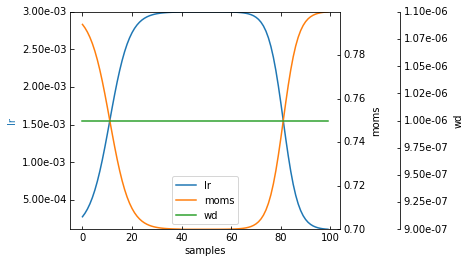

In [20]:
#With sigmnoid
phases = [partial(sigmoid, mid_slope=0.3, slope= 10),
          partial(sigmoid, mid_slope=0.7, slope=-20) ]
samples = 100
tl_lrs  = PhaseStepper( phases, intervals=[.4,.6],limits=(1e-4,3e-3), samples=samples )
lrs     = [v for v in tl_lrs]

tl_moms = PhaseStepper( phases, intervals=[.4,.6],limits=(0.8,.7), samples=samples )
moms    = [v for v in tl_moms]

tl_wd   = PhaseStepper([FunctionStepper()], intervals=[1],limits=1e-6, samples=samples )
wds     = [v for v in tl_wd]

idx     = np.arange(len(lrs),dtype=np.int)
#display( pd.DataFrame(data=np.stack([idx,lrs,moms],axis=0).T,columns=["idx","lr","mom"]) )
print(f"lr:  min:{min(lrs):0.3f} max:{max(lrs):0.3f}")
print(f"mom: min:{min(moms):0.3f} max:{max(moms):0.3f}")
print(f"wd : min:{min(wds)} max:{max(wds)}")
plot_hyperparameters(idx,{"lr":lrs, "moms":moms, "wd":wds} )

lr:  min:0.000 max:0.003
mom: min:0.700 max:0.800


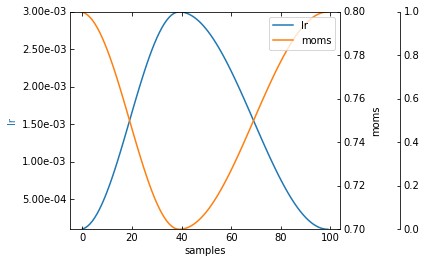

In [21]:
#with cosine annealing
phases = [ partial(annealing_cos),
           partial(annealing_cos,flip_limits=True) ]
samples = 100
tl_lrs = PhaseStepper( phases, [.4,.6], (1e-4,3e-3), samples )
lrs    = [v for v in tl_lrs]

tl_moms = PhaseStepper( phases, [.4,.6], (0.8,.7), samples )
moms    = [v for v in tl_moms]

idx   = np.arange(len(lrs),dtype=np.int)
print(f"lr:  min:{min(lrs):0.3f} max:{max(lrs):0.3f}")
print(f"mom: min:{min(moms):0.3f} max:{max(moms):0.3f}")
plot_hyperparameters(idx,{"lr":lrs, "moms":moms} )

In [22]:
class MyOneCycleScheduler(LearnerCallback):
    "Manage 1-Cycle style training as outlined in Leslie Smith's [paper](https://arxiv.org/pdf/1803.09820.pdf)."
    def __init__( self, learn:Learner, phases:List[PhaseStepper] ):
        super().__init__(learn)
        self.lr_scheds, self.mom_scheds = phases[0], phases[1]
            
    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        "Initialize our optimization params based on our annealing schedule."        
        self.lr_scheds.samples = self.mom_scheds.samples = len(self.learn.data.train_dl) * n_epochs
        self.learn.opt.lr,self.learn.opt.mom = self.lr_scheds.step(), self.mom_scheds.step()
        print(f"on_train_begin lr:{self.opt.lr}, mom:{self.opt.mom}")

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take one step forward on the annealing schedule for the optim params."
        if train:
            #self.opt.lr, self.opt.mom  = self.lr_scheds.step(), self.mom_scheds.step()
            self.learn.opt.lr,self.learn.opt.mom = self.lr_scheds.step(), self.mom_scheds.step()
            print(f"on_batch_end lr:{self.opt.lr}, mom:{self.opt.mom}")

def my_fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[Floats,slice]=defaults.lr,
                     moms:Tuple[float,float]=(0.95,0.85), div_factor:float=25., pct_start:float=0.3,
                     wd:float=None, callbacks:Optional[CallbackList]=None, 
                     lrCurve:PhaseStepper=None,momsCurve:PhaseStepper=None,wdCurve:PhaseStepper=None, **kwargs)->None:
    "Fit a model following the 1cycle policy."
    print("my_fit_one_cycle")

    moms   = tuple(listify(moms,2))
    lr_max = learn.lr_range(max_lr)
    if is_listy(lr_max): lr_max = np.array(lr_max)
    low_lr = lr_max/div_factor        
        
    functions = [partial(sigmoid, mid_slope=0.3, slope= 10),
                 partial(sigmoid, mid_slope=0.7, slope=-20) ]
    phases    = [PhaseStepper( functions, [pct_start,1-pct_start], (low_lr,  lr_max)), 
                 PhaseStepper( functions, [pct_start,1-pct_start], (moms[1], moms[0])) ]
    
    callbacks = listify(callbacks)
    callbacks.append(MyOneCycleScheduler(learn, phases))
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
    
print(f"id(my_fit_one_cycle): {id(my_fit_one_cycle)} id(Learner.fit_one_cycle): {id(Learner.fit_one_cycle)}")
Learner.fit_one_cycle = my_fit_one_cycle
print(f"id(my_fit_one_cycle): {id(my_fit_one_cycle)} id(Learner.fit_one_cycle): {id(Learner.fit_one_cycle)}")

id(my_fit_one_cycle): 112514519112 id(Learner.fit_one_cycle): 112318674328
id(my_fit_one_cycle): 112514519112 id(Learner.fit_one_cycle): 112514519112


In [23]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")

pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
print(f"pad_idx:{pad_idx}")
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathToks/"train", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))
validTokenizer = FileTokenizer(pathToks/"valid", spt_func,"en",vocab,n_cpus=max(defaults.cpus-1,1))

pad_idx:2


In [24]:
minToks = 10
maxToks = 400
nTrainToks, nValidToks = int(5e1),int(1e1)
%time trainIDS = trainTokenizer.getIds(nbSentences=nTrainToks)
%time validIDS = validTokenizer.getIds(nbSentences=nValidToks)
gc.collect()

CPU times: user 600 ms, sys: 93.7 ms, total: 693 ms
Wall time: 695 ms
CPU times: user 812 ms, sys: 119 ms, total: 931 ms
Wall time: 933 ms


22356

In [25]:
%time dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS, validIDS, bptt=35, bs=6, num_workers=0, no_check=True)
gc.collect()

CPU times: user 990 µs, sys: 1e+03 ns, total: 991 µs
Wall time: 1e+03 µs


0

In [26]:
dblm.show_batch(rows=2)

idx,text
0,"▁row an ▁re solv es ▁is ▁the ▁short ▁name ▁for ▁a ▁colonial ▁era ▁document ▁called ▁"" xxmaj re so lution s ▁by ▁inhabitants ▁of ▁row an ▁county ▁concerning ▁resistance ▁to ▁parliamentary ▁taxation ▁and ▁the ▁provincial"
1,"▁suburb . ▁the ▁group ▁has ▁also ▁condemned ▁the - led ▁intervention ▁in ▁with ▁sal im ▁calling ▁it ▁"" an ▁attack ▁on ▁the i ▁people "". ▁after ▁leaving had ▁and"


In [27]:
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=pad_idx,  callback_fns=ShowGraph )

CPU times: user 437 ms, sys: 95.6 ms, total: 533 ms
Wall time: 532 ms


my_fit_one_cycle
before remove params:['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad']
after remove params:['lr', 'betas', 'eps', 'weight_decay', 'amsgrad']
OptimWrapper.read_val:lr cval:[0, 0, 0, 0]
OptimWrapper.read_val:betas cval:([0.9, 0.9, 0.9, 0.9], [0.99, 0.99, 0.99, 0.99])
OptimWrapper.read_val:weight_decay cval:[0, 0, 0, 0]
after wd params:['lr', 'betas', 'eps', 'weight_decay', 'amsgrad']
OptimWrapper.set_val:lr cval:[0.003, 0.003, 0.003, 0.003]
OptimWrapper.set_val:lr cval:[0.0008945512935455861, 0.0008945512935455861, 0.0008945512935455861, 0.0008945512935455861]
OptimWrapper.set_val:betas cval:([0.7268941421369995, 0.7268941421369995, 0.7268941421369995, 0.7268941421369995], [0.99, 0.99, 0.99, 0.99])
on_train_begin lr:0.0008945512935455861, mom:0.7268941421369995


epoch,train_loss,valid_loss,accuracy
1,7.569637,7.662906,0.061472


OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.0022254487064544146, 0.0022254487064544146, 0.0022254487064544146, 0.0022254487064544146]
OptimWrapper.set_val:betas cval:([0.7731058578630006, 0.7731058578630006, 0.7731058578630006, 0.7731058578630006], [0.99, 0.99, 0.99, 0.99])
on_batch_end lr:0.0022254487064544146, mom:0.7731058578630006
OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.002863413485248608, 0.002863413485248608, 0.002863413485248608, 0.002863413485248608]
OptimWrapper.set_val:betas cval:([0.7952574126822434, 0.7952574126822434, 0.7952574126822434, 0.7952574126822434], [0.99, 0.99, 0.99, 0.99])
on_batch_end lr:0.002863413485248608, mom:0.7952574126822434
OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.00298072458933806, 0.00298072458933806, 0.00298072458933806, 0.00298072458933806]
OptimWrapper.set_val:betas cval:([0.7993307149075716, 0.7993307149075716, 0.799330714

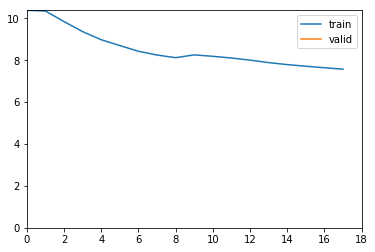

CPU times: user 3min 3s, sys: 6.57 s, total: 3min 9s
Wall time: 47.1 s


In [28]:
%time learn.fit_one_cycle(1,3e-3, moms=(0.8,0.7),pct_start=0.3)

learn.recorder.lrs:
[0.0008945512935455861, 0.0022254487064544146, 0.002863413485248608, 0.00298072458933806, 0.0029973761725601263, 0.0029999888464423605, 0.0029999480539389853, 0.002999758081361655, 0.0029988736294626643, 0.002994761513136387, 0.002975763404318112, 0.0028904905921705096, 0.002552238920189802, 0.0016705512669004051, 0.0006967740620810522, 0.00026695058078132544, 0.0001528689569031804, 0.00012712115469110815]
learn.recorder.moms:
[0.7268941421369995, 0.7731058578630006, 0.7952574126822434, 0.7993307149075716, 0.7999088948805599, 0.7999996127236931, 0.7999981963173259, 0.7999916000472798, 0.7999608899118981, 0.7998181080950135, 0.7991584515388234, 0.7961975900059205, 0.7844527402843682, 0.753838585656264, 0.7200268771555921, 0.7051024507215737, 0.7011412832258048, 0.7002472623156635]


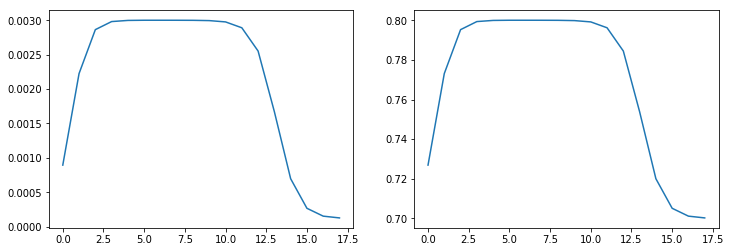

In [29]:
learn.recorder.plot_lr(show_moms=True)
print(f"learn.recorder.lrs:\n{learn.recorder.lrs}")
print(f"learn.recorder.moms:\n{learn.recorder.moms}")

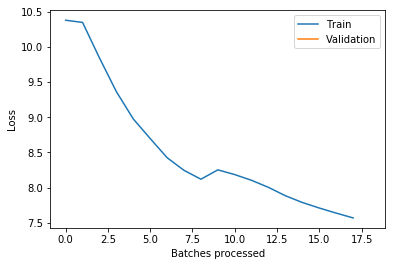

In [30]:
learn.recorder.plot_losses()

my_fit_one_cycle
OptimWrapper.set_val:lr cval:[0.00021882987290360977, 0.0007823559780804169, 0.002797062705912073, 0.009999999999999998]
OptimWrapper.set_val:lr cval:[6.52515152907801e-05, 0.00023328585073498638, 0.0008340386872339208, 0.002981837645151953]
OptimWrapper.set_val:betas cval:([0.7268941421369995, 0.7268941421369995, 0.7268941421369995, 0.7268941421369995], [0.99, 0.99, 0.99, 0.99])
on_train_begin lr:0.002981837645151953, mom:0.7268941421369995


epoch,train_loss,valid_loss,accuracy
1,5.854187,7.794514,0.083983


OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.00016233155252897409, 0.0005803643664686473, 0.0020749065269146357, 0.0074181623548480475]
OptimWrapper.set_val:betas cval:([0.7731058578630006, 0.7731058578630006, 0.7731058578630006, 0.7731058578630006], [0.99, 0.99, 0.99, 0.99])
on_batch_end lr:0.0074181623548480475, mom:0.7731058578630006
OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.00020886680301581174, 0.00074673621930011, 0.002669715690398197, 0.009544711617495358]
OptimWrapper.set_val:betas cval:([0.7952574126822434, 0.7952574126822434, 0.7952574126822434, 0.7952574126822434], [0.99, 0.99, 0.99, 0.99])
on_batch_end lr:0.009544711617495358, mom:0.7952574126822434
OptimWrapper.set_val:weight_decay cval:[0, 0, 0, 0]
OptimWrapper.set_val:lr cval:[0.0002174238610151707, 0.0007773292338266423, 0.002779091195144189, 0.009935748631126866]
OptimWrapper.set_val:betas cval:([0.7993307149075716, 0.7993307149075716, 0.7

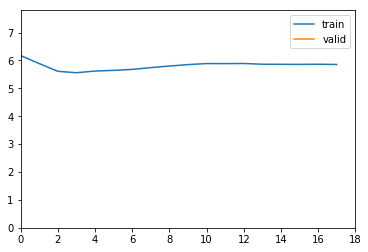

In [31]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))